In [2]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi

Mounted at /content/drive


In [89]:
print('Importing Libraries')

import pandas as pd
import numpy as np
import pickle as pkl
from textblob import TextBlob
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

print('Libraries Imported')

Importing Libraries
Libraries Imported


In [20]:
df = pd.read_csv('/content/drive/My Drive/datasets/sentiment_analysis/Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [73]:
# ---------------- Take only english character and numbers--------------

def clean_text(x):
    import string
    import re
    sent = ''
    for i in x:
        if(i in string.printable):
            sent+=i
    new_sent = ''
    for i in sent:
        if(i in string.ascii_letters+' '+'0123456789'):
            new_sent+=i
            
    new_sent= re.sub('\s+', ' ', new_sent)

    return new_sent.lower()

def remove_stopwords(input_text):
    "Removing stop words from the sentences"
    stopwords_list = stopwords.words('english')
    stopwords_list.extend('br')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words).lower()

In [74]:
# checking if there any sentence without any sentiment given
print('Any review without sentiment: ', df['sentiment'].isnull().any())
print('Unique sentiments: ', df['sentiment'].unique())

# encoding the sentiment
df['sentiment_index'] = np.where(df['sentiment'] == 'positive', 1, 0)

# removing extra characters from the text
df['clean_review'] = df['review'].apply(clean_text)

# removing stop words from the text except no, not and n't
df['clean_review'] = df['clean_review'].apply(remove_stopwords)
df.head()

Any review without sentiment:  False
Unique sentiments:  ['positive' 'negative']


,review,sentiment,sentiment_index,clean_review,review_class
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mentioned watching oz episode yo...,0
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production br br filming tech...,0
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...,0
3,Basically there's a family where a little boy ...,negative,0,basically theres family little boy jake thinks...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stunni...,0


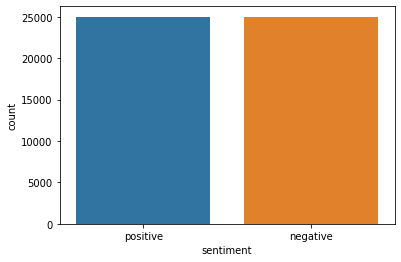

In [45]:
# Target count
sns.countplot(df['sentiment'])
plt.show()

**Sentiment Analysis using TextBlob**

In [56]:
def predict_sentiment_score(review):
    polarity = TextBlob(review).sentiment.polarity
    if polarity >= 0.4:
        return 1
    else:
        return 0

df['review_class'] = df['clean_review'].apply(predict_sentiment_score)

# df.head()

In [53]:
print('Accuracy: ', accuracy_score(df['sentiment_index'], df['review_class']))
print('Precision: ', precision_score(df['sentiment_index'], df['review_class']))
print('Recall: ', recall_score(df['sentiment_index'], df['review_class']))
print('F1 score :', f1_score(df['sentiment_index'], df['review_class']))
print('Confusion Matrix:', confusion_matrix(df['sentiment_index'], df['review_class']))

Accuracy:  0.51114
Precision:  0.9470304975922953
Recall:  0.0236
F1 score : 0.04605237481949811
Confusion Matrix: [[24967    33]
 [24410   590]]


**Using Deep Learning**

**TFIDF**

In [57]:
df_dl = df[['clean_review', 'sentiment_index']].copy()

In [58]:
reviews = df_dl['clean_review'].values
review_class = df_dl['sentiment_index'].values

In [61]:

# number of words has to be taken to train the model
words_count = 1000

# Initializing the Keras Tokenizer to tokenize the reviews and create feature vector
tokenizer = Tokenizer(words_count,
                      lower=True)

# fitting the tokenizer to tokenize the text
tokenizer.fit_on_texts(reviews)
with open('/content/drive/My Drive/datasets/sentiment_analysis/tokenizer.pkl', 'wb') as f:
    pkl.dump(tokenizer, f)
# size of the build Vocabulary
# print(len(tokenizer.word_index))

# converting text into numbers using TF-IDF
features = tokenizer.texts_to_matrix(reviews, mode='tfidf')

print(features.shape)

180760
(50000, 1000)


model building

In [70]:
model = Sequential()

# model.add(BatchNormalization(input_shape=(words_count, )))
model.add(Dense(words_count, input_dim=words_count, activation='relu'))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_12 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)               

In [71]:
batch_size = 32
filepath="/content/drive/My Drive/datasets/sentiment_analysis/cnn/cnn_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, EarlyStopping(patience = 15)]
history = model.fit(features, review_class,
          validation_split=0.30,
          callbacks=callbacks_list,
          epochs=100,
          batch_size = batch_size,
          verbose=3).history

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.85540, saving model to /content/drive/My Drive/datasets/sentiment_analysis/cnn/weights-improvement-01-0.86.hdf5
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.85540 to 0.85613, saving model to /content/drive/My Drive/datasets/sentiment_analysis/cnn/weights-improvement-02-0.86.hdf5
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.85613
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.85613
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.85613
Epoch 6/100

Epoch 00006: val_accuracy did not improve from 0.85613
Epoch 7/100

Epoch 00007: val_accuracy did not improve from 0.85613
Epoch 8/100

Epoch 00008: val_accuracy did not improve from 0.85613
Epoch 9/100

Epoch 00009: val_accuracy did not improve from 0.85613
Epoch 10/100

Epoch 00010: val_accuracy did not improve from 0.85613
Epoch 11/100

Epoch 00011: val_accuracy did not improve from 0.85613
Epoch 12/100

Epoch 00012: val_ac

Train Max Accuracy:  0.9978285431861877
Val Max Accuracy:  0.8561333417892456
Train Min Loss:  0.007483073975890875
Val Min Loss:  0.3321588933467865


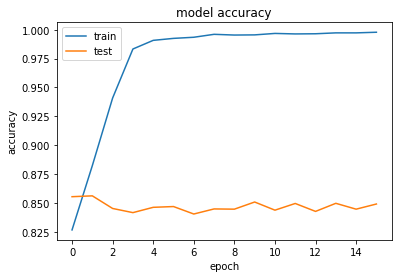

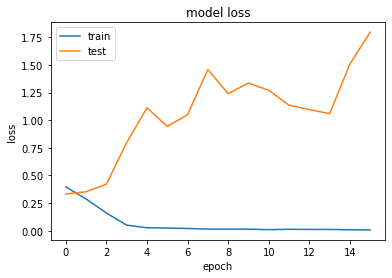

In [72]:
print('Train Max Accuracy: ', max(history['accuracy']))
print('Val Max Accuracy: ', max(history['val_accuracy']))
print('Train Min Loss: ', min(history['loss']))
print('Val Min Loss: ', min(history['val_loss']))


# list all data in history
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Using LSTM

In [78]:
# Using already created feature vector

max_words = 500
features = sequence.pad_sequences(features, maxlen=max_words)

In [83]:
embedding_size=64

model=Sequential()

model.add(Embedding(words_count, embedding_size, input_length=max_words))

model.add(LSTM(max_words))

model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               1130000   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 501       
Total params: 1,194,501
Trainable params: 1,194,501
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [85]:
batch_size = 64
filepath="/content/drive/My Drive/datasets/sentiment_analysis/lstm/lstm_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, EarlyStopping(patience = 15)]
model.fit(features, review_class,
          validation_split=0.20, 
          callbacks=callbacks_list,
          batch_size = batch_size,
          epochs = 100,
          verbose=3)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.50940, saving model to /content/drive/My Drive/datasets/sentiment_analysis/lstm/weights-improvement-01-0.51.hdf5
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.50940
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.50940
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.50940 to 0.51240, saving model to /content/drive/My Drive/datasets/sentiment_analysis/lstm/weights-improvement-04-0.51.hdf5
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.51240 to 0.51840, saving model to /content/drive/My Drive/datasets/sentiment_analysis/lstm/weights-improvement-05-0.52.hdf5
Epoch 6/100

Epoch 00006: val_accuracy did not improve from 0.51840
Epoch 7/100

Epoch 00007: val_accuracy did not improve from 0.51840
Epoch 8/100

Epoch 00008: val_accuracy did not improve from 0.51840
Epoch 9/100

Epoch 00009: val_accuracy did not improve from 0.51840
Epoch 10/100

Epoch 00010: val_accuracy did not improve fr

Train Max Accuracy:  0.5904250144958496
Val Max Accuracy:  0.5730999708175659
Train Min Loss:  0.6543943881988525
Val Min Loss:  0.678179919719696


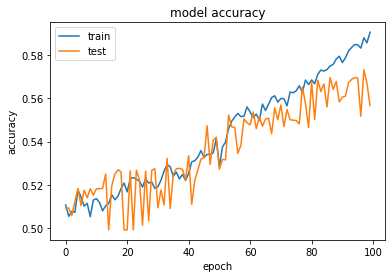

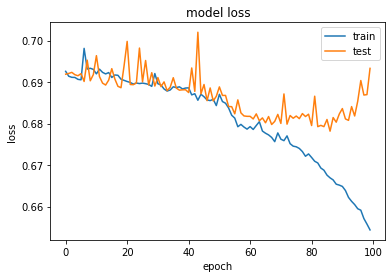

In [87]:
history = model.history.history

print('Train Max Accuracy: ', max(history['accuracy']))
print('Val Max Accuracy: ', max(history['val_accuracy']))
print('Train Min Loss: ', min(history['loss']))
print('Val Min Loss: ', min(history['val_loss']))

# list all data in history
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

The model requires more training to train well and give good accuracy

**USING Logistic Regression**

In [145]:
# Using already created feature vector
max_words = 500
features = sequence.pad_sequences(features, maxlen=max_words)
print('Padded Feature Vector: ', features.shape)

Padded Feature Vector:  (50000, 500)


In [146]:
train_x, test_x, train_y, test_y = train_test_split(features, review_class, test_size=0.2)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(40000, 500) (40000,) (10000, 500) (10000,)


In [147]:
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt

log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [148]:
pred_y = log_reg.predict(test_x)

In [150]:
accuracy = accuracy_score(test_y, pred_y)
print('Accuracy: ', accuracy)
print('Precision: ', precision_score(test_y, pred_y))
print('Recall: ', recall_score(test_y, pred_y))
print('F1 score :', f1_score(test_y, pred_y))
print('Confusion Matrix:', confusion_matrix(test_y, pred_y))
with open('/content/drive/My Drive/datasets/sentiment_analysis/log_reg_'+str(accuracy)+'_'+str(dt.now())+'.pkl', 'wb') as f:
    pkl.dump(log_reg, f)

Accuracy:  0.6077
Precision:  0.5841461526552097
Recall:  0.7530938123752495
F1 score : 0.657947510680966
Confusion Matrix: [[2304 2686]
 [1237 3773]]
